# FISH - Pipeline - A Python notebook to visualize FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')


### Paths to folders

In [3]:
# Substring in folder
mandatory_substring='nuc_70__cyto_0__psfz_350__psfyx_160__ts_550_400'
connect_to_NAS = True
# Path to folder
data_folder_path = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_woStim')


### Downloading data

In [4]:
%%capture
list_images, list_masks, complete_dataframe, number_images, number_color_channels = fa.Utilities.extract_images_masks_dataframe( data_folder_path,
                                                                                                                                mandatory_substring, 
                                                                                                                                path_to_config_file,
                                                                                                                                connect_to_NAS)

----
# User parameters
___

In [5]:
# Selecting cell to visualize
cell_id = 0
# minimal number of mRNA for consider a cluster a transcription site.
min_ts_size = 10 # Use None as the default value used on your exisiting dataframe

In [6]:
# Extracting image with cell and specific dataframe
subsection_image_with_selected_cell, df_spots_subsection_coordinates,_,_ = fa.Utilities.image_cell_selection(cell_id=cell_id, 
                                                                                                         list_images=list_images, 
                                                                                                         dataframe=complete_dataframe)

# Plotting composed-color channels

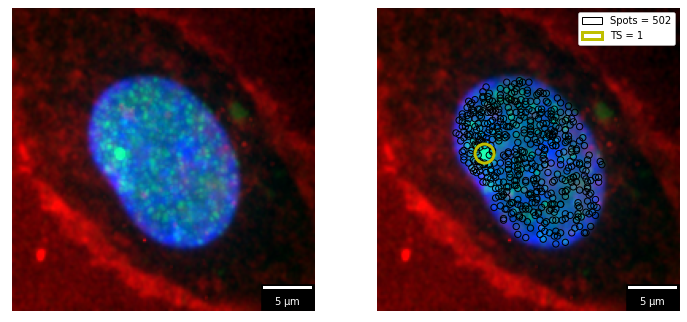

In [7]:
fa.Plots.plot_selected_cell_colors(image=subsection_image_with_selected_cell,
                                    df= df_spots_subsection_coordinates, 
                                    min_ts_size=min_ts_size, 
                                    show_spots=True,
                                    use_gaussian_filter = True,
                                    show_legend = True,
                                    microns_per_pixel = 0.16)

# Plotting detected spots on a single color channel 

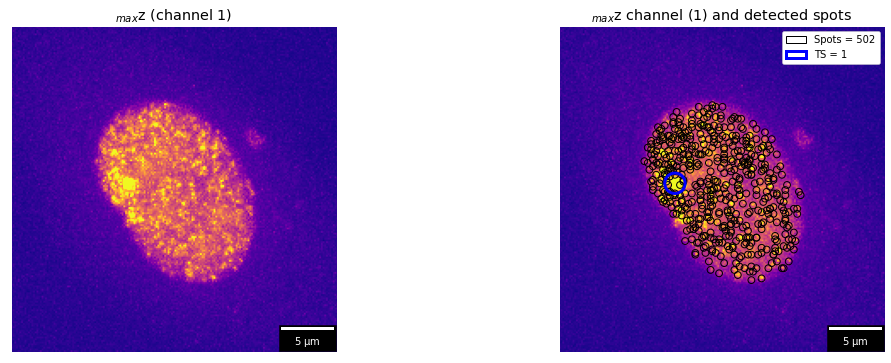

In [8]:
fa.Plots.plot_single_cell(image=subsection_image_with_selected_cell, 
                            df=df_spots_subsection_coordinates, 
                            selected_channel=1, 
                            min_ts_size=min_ts_size,
                            show_spots=True,
                            show_legend = True,
                            image_name=None,
                            microns_per_pixel = 0.16)

In [9]:
raise

RuntimeError: No active exception to reraise

## Plotting all color channels

In [ ]:
fa.Plots.plot_single_cell_all_channels(image=subsection_image_with_selected_cell, 
                                        df=df_spots_subsection_coordinates, 
                                        min_ts_size=min_ts_size,
                                        image_name=None,
                                        show_spots = False,
                                        microns_per_pixel=0.16)

# Plotting z-slices for all channels

In [ ]:
fa.Plots.plot_cell_all_z_planes(image=subsection_image_with_selected_cell, image_name=None )

# Plotting a color image for a Field of View

In [ ]:
fa.Plots.plot_complete_fov(list_images=list_images,
                            df=complete_dataframe, 
                            number_of_selected_image = 0, 
                            use_GaussianFilter=True,
                            microns_per_pixel = 0.16,
                            show_cell_ids=True)

## Plotting all cells

In [ ]:
fa.Plots.plot_all_cells(list_images, complete_dataframe, selected_channel=1, spot_type=0,min_ts_size=6,show_spots=True,image_name=None,microns_per_pixel=None,show_legend = True,)

In [ ]:
fa.Plots.plot_all_cells_and_spots(list_images, 
                                  complete_dataframe, 
                                  selected_channel=1, 
                                  spot_type=0,
                                  min_ts_size=6,
                                  image_name=None,
                                  microns_per_pixel=0.16,
                                  show_legend = True)